# Lab Assignment Six: Convolutional Network Architectures

Yifu Zhang, Yue li, Weiyi Zhao, Siwei Wang

Nov.24,2018

## 1. Preparation and Overview

### 1.1 Data Description

For this project, we are using fruit 360 dataset from Kaggle. [1] This dataset contains 81 fruits and 55244 images. But we only select a subset of data from this dataset. In this project, we pick 14 distinct fruit categories to generate our dataset, which is also means there are 14 classes for our variable. Those classes are ‘Apple Red1’,’Banana’,’Avocado’,’Cherry1’, ‘Litchi’, ‘Cocos’, ‘Strawberry’, ‘Mango’, ‘Grape Pink’, ‘Pineapple’, ‘Lemon’, ‘Orange’, ‘Pear’, ‘Tomato1’.  The original images are in identical size as well as the pixels. So, there is no need to reshape those images. Our final dataset contains 4834 images.

### 1.2 Business Understanding

Identifying fruits among various shopping goods in supermarket has been tedious and ineffective. Grocery stores must prepare the coding label, while customers and cashiers must key in code when checking out. An automated fruit identification system ensembled in the self-checking-out system will improve the redundant labeling process and save resources and labor. In this project, our primary purpose is to classify the category of fruit based on the images. Such algorithm can be used as the automated fruit identification system in the supermarket. 

### 1.3 Evaluation Metrics

In many classification tasks, false predictions result in irreparable loss. Such as in terrorist’s detection, a false negative result, which means the target is a terrorist but classified as a non-terrorist, could cause numerous severe deaths. Another example is disease diagnostics, a false positive result, meaning that patient is diagnosed as a malignant tumor patient but is health, will be advised to take series of treatment that might cause illness. However, in our application scenario, a false identification won’t do much harm. False classified items can be manually corrected when checking out. Thus, false negative and false positive results are unimportant in our case. And considering an even class dataset, we decided to use accuracy instead of F1 score as our model performance measuring metric.

### 1.4 Cross Validation Methods
For cross validation, we use the Stratified ShuffleSplit iterator. During each iteration, the dataset will be randomly sampled into a training set and a test set. The proportion of each set can be controlled by the size parameters. While in K-Fold procedure, original dataset will be seperated into prespecified number of folds. And in each of the k times validation, one of the fold will be used for training and rest of the data set will be used for testing. As dataset increasses, shuffle split method with fine control on split parameters will be more efficient than K-Fold method. Considering our slight class distribution imbalance, we use stratified shuffle split method.

## 2. Modeling

In [ ]:
import numpy as np
import cv2
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
from sklearn.metrics import accuracy_score
import keras
from keras import backend as K
from keras.models import Sequential, Input, Model
from keras.layers import Reshape, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, UpSampling2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from scipy import interp
from sklearn import metrics as mt
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns



### 2.1 Data Preparation

We choose 14 different fruits to train and valiadate our model. Some of them might look similar, such as mango, orange and lemon.

1.   Apple Red
2.   Banana
3.   Avocado
4.   Cherry
5.   Litchi
6.   Cocos
7.   Strawberry
8.   Mango
9.   Grape Pink
10. Pineapple
11. Lemon
12. Orange
13. Pear
14. Tomato

Each image is resized as 32*32 and converted into  RGB2BGR color space.







In [ ]:
fruits = ['Apple Red1','Banana','Avocado','Cherry1',
          'Litchi','Cocos','Strawberry','Mango','Grape Pink',
          'Pineapple',  'Lemon', 'Orange','Pear', 'Tomato1']
x_train = []
y_train = [] 
i = 0
for fruit in fruits:
    fruit_dir_path = "fruits-360/Training/" + fruit
    fruit_label = fruit_dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (32, 32))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        x_train.append(image)
        y_train.append(i)
    i = i + 1
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = []
y_test = [] 

i = 0
for fruit in fruits:
    fruit_dir_path = "fruits-360/Test/" + fruit
    fruit_label = fruit_dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (32, 32))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        x_test.append(image)
        y_test.append(i)
    i = i+1
x_test = np.array(x_test)
y_test = np.array(y_test)

C:\Users\zhang\Anaconda\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\zhang\Anaconda\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)
C:\Users\zhang\Anaconda\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)
C:\Users\zhang\Anaconda\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


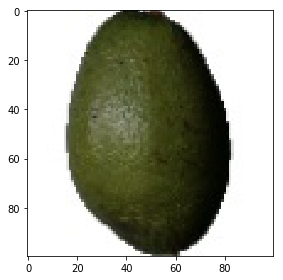

In [ ]:
from skimage import color,transform,io
im="fruits-360/Training/Avocado/*.jpg"
images = io.ImageCollection(im)
io.imshow(images[1])
plt.show()

### 2.2 Data expansion

For fruit recognition, some fruits might look simialr in certain angle. In order to take that scenario into consideration, we expand our data set by image expansion techniques, like rotation and width and height shifting.  

In [ ]:
NUM_CLASSES = 14
y_train_ohot = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohot = keras.utils.to_categorical(y_test, NUM_CLASSES)
y_train_ohot.shape

(4834, 14)

In [ ]:
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

datagen.fit(x_train)

idx = 0


In [ ]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def plot_roc(probas, y_true):
    plt.figure(figsize=(15,5))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    classes = np.unique(y_true)
    perclass_mean_tpr = 0.0
    roc_auc = 0
    for j in classes:
        fpr, tpr, thresholds = mt.roc_curve(y_true, probas[:, j], pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += mt.auc(fpr, tpr)
        plt.plot(fpr,tpr,'--',lw=.5,label='Class ROC for ensemble, AUC=%0.4f'
                     %(mt.auc(fpr, tpr)) )

    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr

    plt.plot(mean_fpr,perclass_mean_tpr,'-',lw=2,label='Mean Class ROC for ensemble, AUC=%0.4f'
                     %(roc_auc))
    plt.legend(loc='best')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('ROC Curve')

def compare_mlp_cnn(cnn,x_test, y_test):
    plt.figure(figsize=(15,5))
    yhat_cnn = np.argmax(cnn.predict(x_test), axis=1)
    acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
    plt.subplot(1,2,1)
    cm = mt.confusion_matrix(y_test,yhat_cnn)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title('CNN: '+str(acc_cnn))

### 2.3 Simple CNN

In [ ]:
cnn = Sequential()

# let's start with a simple CNN
cnn.add(Conv2D(filters = 16,
                input_shape = (32,32,3),
                kernel_size=(5,5), 
                padding='valid', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))


# add one layer on flattened output
cnn.add(Flatten())
cnn.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn.compile(loss='mean_squared_error', # 'categorical_crossentropy' // 'mean_squared_error'
              optimizer='adadelta', # 'adadelta'  // 'rmsprop'
              metrics=['accuracy'])


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import cross_validation
cv = StratifiedShuffleSplit(n_splits=2, test_size=.2)
#StratifiedShuffleSplit(n_splits=2, test_size=.2)

In [ ]:
# cross validation 
score = []
history = []
for train_index, test_index in cv.split(x_train, y_train_ohot):
   
    history_new = cnn.fit_generator(datagen.flow(x_train, y_train_ohot,
                                                 batch_size=10), 
                       steps_per_epoch=int(len(x_train)/10), # how many generators to go through per epoch
                       epochs=10, verbose=1,
                       validation_data=(x_test,y_test_ohot)
                      )
    yhat = np.argmax(cnn.predict(x_test), axis=1)
    y_test = []
    for i in range(len(y_test_ohot)):
        y_test.append(np.argmax(y_test_ohot[i]))
    
    y_test = np.array(y_test) 
    
    # Accuracy
    acc = mt.accuracy_score(y_test,yhat)
    history.append(history_new)

Epoch 1/10
483/483 [==============================] - 8s 17ms/step - loss: 0.1381 - acc: 0.0333 - val_loss: 0.1429 - val_acc: 0.0000e+00
Epoch 2/10
483/483 [==============================] - 5s 10ms/step - loss: 0.1429 - acc: 0.0000e+00 - val_loss: 0.1429 - val_acc: 0.0000e+00
Epoch 3/10
483/483 [==============================] - 5s 10ms/step - loss: 0.1429 - acc: 0.0000e+00 - val_loss: 0.1429 - val_acc: 0.0000e+00
Epoch 4/10
483/483 [==============================] - 5s 10ms/step - loss: 0.1429 - acc: 0.0000e+00 - val_loss: 0.1429 - val_acc: 0.0000e+00
Epoch 5/10
483/483 [==============================] - 5s 11ms/step - loss: 0.1429 - acc: 0.0000e+00 - val_loss: 0.1429 - val_acc: 0.0000e+00
Epoch 6/10
483/483 [==============================] - 5s 10ms/step - loss: 0.1429 - acc: 0.0000e+00 - val_loss: 0.1429 - val_acc: 0.0000e+00
Epoch 7/10
483/483 [==============================] - 5s 11ms/step - loss: 0.1429 - acc: 0.0000e+00 - val_loss: 0.1429 - val_acc: 0.0000e+00
Epoch 8/10
483/48

C:\Users\zhang\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\zhang\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\zhang\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:10

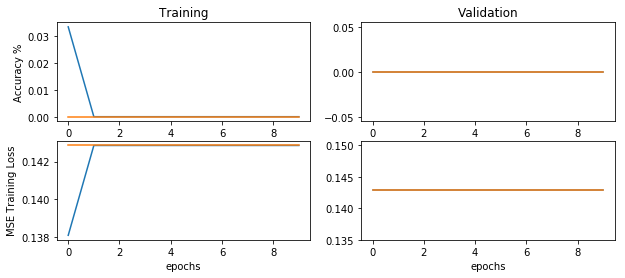

In [ ]:

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
for i in range(len(history)):
    plt.plot(history[i].history['acc'])
    plt.ylabel('Accuracy %')
    plt.title('Training')

for i in range(len(history)):
    plt.subplot(2,2,2)
    plt.plot(history[i].history['val_acc'])
    plt.title('Validation')

for i in range(len(history)):
    plt.subplot(2,2,3)
    plt.plot(history[i].history['loss'])
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')

for i in range(len(history)):
    plt.subplot(2,2,4)
    plt.plot(history[i].history['val_loss'])
    plt.xlabel('epochs')

C:\Users\zhang\Anaconda\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


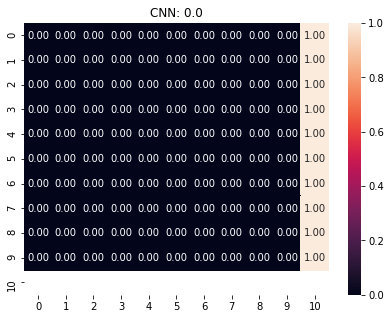

In [ ]:
compare_mlp_cnn(cnn,x_test,y_test)

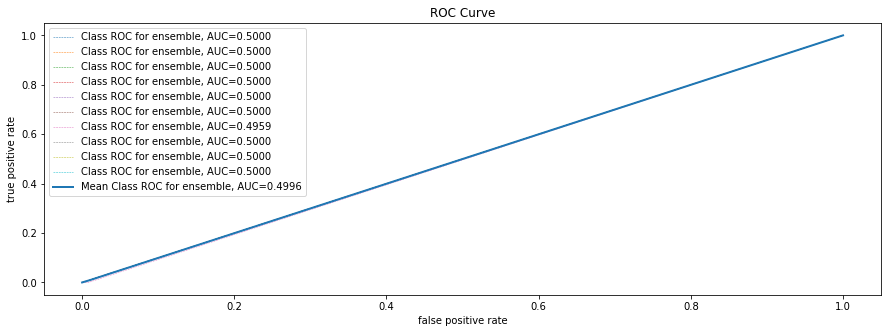

In [ ]:
probas = cnn.predict_proba(x_test)
plot_roc(probas, y_test)

The first result basically shows that all samples are predicted as the first fruit class. We think this anomaly is caused by uncomparable features in our data set. Adding batch normalization should help. During back propagation, outliers and little perturbation in initial layers causes distraction to gradients, meaning the gradients have to compensate the outliers, before learning the weights to produce required outputs. Batch normalization regularizes these gradient from distraction to outliers and flow towards a range of the mini-batch.

### 2.4 Simple CNN with BatchNormalization

In [ ]:
cnn1 = Sequential()

# simple CNN with Batch Normalization
cnn1.add(Conv2D(filters = 16,
                input_shape = (32,32,3),
                kernel_size=(5,5), 
                padding='valid', 
                activation='relu')) 
cnn1.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
cnn1.add(BatchNormalization())

# add one layer on flattened output
cnn1.add(Flatten())
cnn1.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn1.compile(loss='mean_squared_error', # 'categorical_crossentropy' //'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' // 'rmsprop'
              metrics=['accuracy'])


In [ ]:
score = []
history = []
for train_index, test_index in cv.split(x_train, y_train_ohot):
   
    history_new = cnn1.fit_generator(datagen.flow(x_train, y_train_ohot,
                                                 batch_size=10), 
                       steps_per_epoch=int(len(x_train)/10), # how many generators to go through per epoch
                       epochs=10, verbose=1,
                       validation_data=(x_test,y_test_ohot)
                      )
    yhat = np.argmax(cnn.predict(x_test), axis=1)
    y_test = []
    for i in range(len(y_test_ohot)):
        y_test.append(np.argmax(y_test_ohot[i]))
    
    y_test = np.array(y_test) 
    
    # Accuracy
    acc = mt.accuracy_score(y_test,yhat)
    history.append(history_new)

Epoch 1/10
483/483 [==============================] - 10s 20ms/step - loss: 0.0130 - acc: 0.8731 - val_loss: 0.0015 - val_acc: 0.9852
Epoch 2/10
483/483 [==============================] - 7s 13ms/step - loss: 0.0030 - acc: 0.9723 - val_loss: 0.0432 - val_acc: 0.6852
Epoch 3/10
483/483 [==============================] - 6s 13ms/step - loss: 0.0021 - acc: 0.9807 - val_loss: 0.0055 - val_acc: 0.9501
Epoch 4/10
483/483 [==============================] - 7s 14ms/step - loss: 0.0014 - acc: 0.9871 - val_loss: 2.7504e-04 - val_acc: 0.9982
Epoch 5/10
483/483 [==============================] - 6s 13ms/step - loss: 0.0015 - acc: 0.9865 - val_loss: 0.0136 - val_acc: 0.8909
Epoch 6/10
483/483 [==============================] - 7s 14ms/step - loss: 8.7746e-04 - acc: 0.9921 - val_loss: 2.6613e-04 - val_acc: 0.9994
Epoch 7/10
483/483 [==============================] - 7s 14ms/step - loss: 9.1774e-04 - acc: 0.9919 - val_loss: 0.0900 - val_acc: 0.3500
Epoch 8/10
483/483 [==============================] 

C:\Users\zhang\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\zhang\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\zhang\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:10

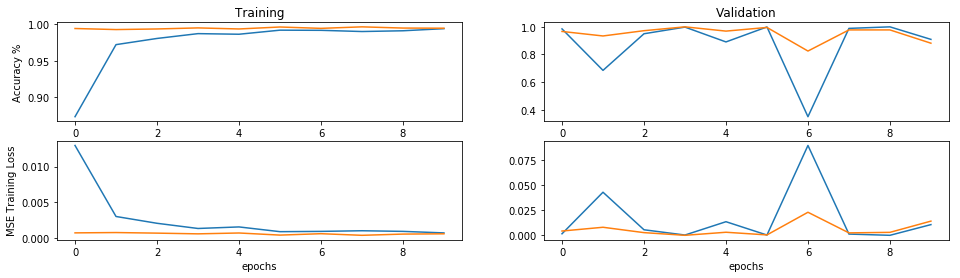

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(2,2,1)
for i in range(len(history)):
    plt.plot(history[i].history['acc'])
    plt.ylabel('Accuracy %')
    plt.title('Training')

for i in range(len(history)):
    plt.subplot(2,2,2)
    plt.plot(history[i].history['val_acc'])
    plt.title('Validation')

for i in range(len(history)):
    plt.subplot(2,2,3)
    plt.plot(history[i].history['loss'])
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')

for i in range(len(history)):
    plt.subplot(2,2,4)
    plt.plot(history[i].history['val_loss'])
    plt.xlabel('epochs')

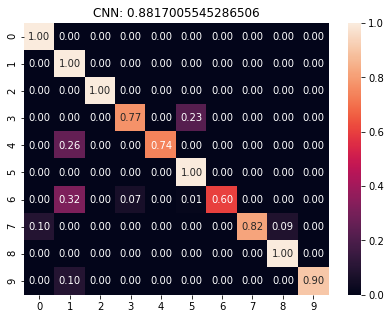

In [ ]:
compare_mlp_cnn(cnn1,x_test,y_test)

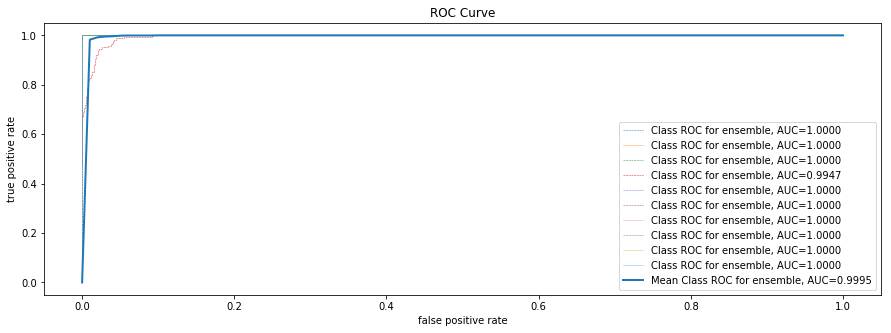

In [ ]:
probas = cnn1.predict_proba(x_test)
plot_roc(probas, y_test)

### 2.5 Simple CNN with a smaller Kernal_size as well data_format

In [ ]:
cnn2 = Sequential()

# let's start with an AlexNet style convolutional phase
cnn2.add(Conv2D(filters = 16,
                input_shape = (32,32,3),
                kernel_size=(3,3), 
                padding='valid', 
                activation='relu')) # more compact syntax

cnn2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
cnn2.add(BatchNormalization())

cnn2.add(Flatten())
cnn2.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn2.compile(loss='mean_squared_error', # 'categorical_crossentropy' // 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' // 'rmsprop'
              metrics=['accuracy'])


In [ ]:
score = []
history = []
for train_index, test_index in cv.split(x_train, y_train_ohot):
   
    history_new = cnn2.fit_generator(datagen.flow(x_train, y_train_ohot,
                                                 batch_size=10), 
                       steps_per_epoch=int(len(x_train)/10), # how many generators to go through per epoch
                       epochs=10, verbose=1,
                       validation_data=(x_test,y_test_ohot)
                      )
    yhat = np.argmax(cnn.predict(x_test), axis=1)
    y_test = []
    for i in range(len(y_test_ohot)):
        y_test.append(np.argmax(y_test_ohot[i]))
    
    y_test = np.array(y_test) 
    
    # Accuracy
    acc = mt.accuracy_score(y_test,yhat)
    history.append(history_new)

Epoch 1/10
483/483 [==============================] - 9s 19ms/step - loss: 0.0175 - acc: 0.8354 - val_loss: 0.0035 - val_acc: 0.9630
Epoch 2/10
483/483 [==============================] - 6s 12ms/step - loss: 0.0039 - acc: 0.9638 - val_loss: 0.0160 - val_acc: 0.8718
Epoch 3/10
483/483 [==============================] - 6s 12ms/step - loss: 0.0032 - acc: 0.9700 - val_loss: 0.0028 - val_acc: 0.9760
Epoch 4/10
483/483 [==============================] - 6s 12ms/step - loss: 0.0023 - acc: 0.9787 - val_loss: 0.0104 - val_acc: 0.9131
Epoch 5/10
483/483 [==============================] - 6s 12ms/step - loss: 0.0019 - acc: 0.9824 - val_loss: 2.8682e-04 - val_acc: 0.9969
Epoch 6/10
483/483 [==============================] - 6s 12ms/step - loss: 0.0021 - acc: 0.9795 - val_loss: 7.6287e-05 - val_acc: 0.9994
Epoch 7/10
483/483 [==============================] - 6s 12ms/step - loss: 0.0014 - acc: 0.9870 - val_loss: 0.0043 - val_acc: 0.9655
Epoch 8/10
483/483 [==============================] - 6s 12ms

C:\Users\zhang\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\zhang\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\zhang\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:10

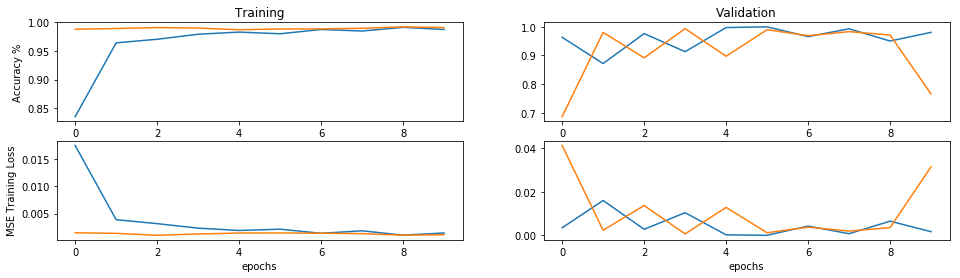

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(2,2,1)
for i in range(len(history)):
    plt.plot(history[i].history['acc'])
    plt.ylabel('Accuracy %')
    plt.title('Training')

for i in range(len(history)):
    plt.subplot(2,2,2)
    plt.plot(history[i].history['val_acc'])
    plt.title('Validation')

for i in range(len(history)):
    plt.subplot(2,2,3)
    plt.plot(history[i].history['loss'])
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')

for i in range(len(history)):
    plt.subplot(2,2,4)
    plt.plot(history[i].history['val_loss'])
    plt.xlabel('epochs')

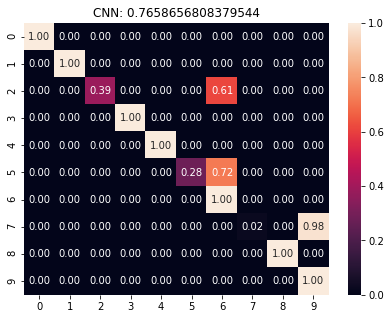

In [ ]:

compare_mlp_cnn(cnn2,x_test,y_test)

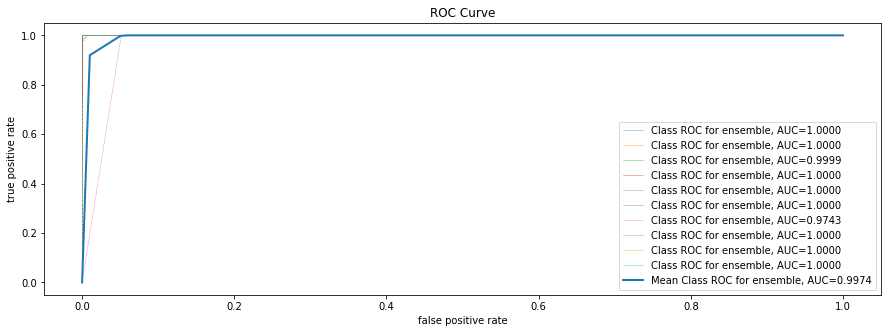

In [ ]:
probas = cnn2.predict_proba(x_test)
plot_roc(probas, y_test)

With smaller kernel size, the output matrix will increase. So it will provide more information and the model should perform better when making predictions.

### 2.6 Two layer Alexnet (more layers take long times)

The Alexnet is charactarized by 3 main layers: two 2-dimensional convolution layers, with one 2-dimensional max pooling layers inbetween. we can use this model on our fruit dataset. We achieved the best results using 16 3x3px filters, followed by 64 3x3 filters. 

In [ ]:
#lets try a four layer alexnet CNN
cnn3 = Sequential()

cnn3.add(Conv2D(filters = 16,
                input_shape = (32,32,3),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu'))

cnn3.add(Conv2D(filters = 64,
                kernel_size = (3,3), 
                padding='same', 
                activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
cnn3.add(BatchNormalization())


#################

cnn3.add(Dropout(0.25)) # add some dropout 
cnn3.add(Flatten())
cnn3.add(Dense(128, activation='relu'))
cnn3.add(Dropout(0.5)) # add some dropout 
cnn3.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn3.compile(loss='mean_squared_error', # 'categorical_crossentropy' //'mean_squared_error'
              optimizer='adadelta', # 'adadelta' //'rmsprop'
              metrics=['accuracy'])

In [ ]:
score = []
history = []
for train_index, test_index in cv.split(x_train, y_train_ohot):
    
    history_new = cnn3.fit_generator(datagen.flow(x_train, y_train_ohot,
                                                 batch_size=10), 
                       steps_per_epoch=int(len(x_train)/10), # how many generators to go through per epoch
                       epochs=10, verbose=1,
                       validation_data=(x_test,y_test_ohot)
                      )
    yhat = np.argmax(cnn.predict(x_test), axis=1)
    y_test = []
    for i in range(len(y_test_ohot)):
        y_test.append(np.argmax(y_test_ohot[i]))
    
    y_test = np.array(y_test) 
    
    # Accuracy
    acc = mt.accuracy_score(y_test,yhat)
    history.append(history_new)

Epoch 1/10
483/483 [==============================] - 38s 78ms/step - loss: 0.0370 - acc: 0.6429 - val_loss: 0.0052 - val_acc: 0.9421
Epoch 2/10
483/483 [==============================] - 34s 69ms/step - loss: 0.0072 - acc: 0.9360 - val_loss: 7.7349e-06 - val_acc: 1.0000
Epoch 3/10
483/483 [==============================] - 34s 70ms/step - loss: 0.0036 - acc: 0.9679 - val_loss: 4.0560e-06 - val_acc: 1.0000
Epoch 4/10
483/483 [==============================] - 34s 70ms/step - loss: 0.0023 - acc: 0.9784 - val_loss: 3.7245e-08 - val_acc: 1.0000
Epoch 5/10
483/483 [==============================] - 34s 69ms/step - loss: 0.0016 - acc: 0.9863 - val_loss: 1.3257e-06 - val_acc: 1.0000
Epoch 6/10
483/483 [==============================] - 34s 70ms/step - loss: 0.0017 - acc: 0.9865 - val_loss: 7.4157e-07 - val_acc: 1.0000
Epoch 7/10
483/483 [==============================] - 34s 70ms/step - loss: 0.0012 - acc: 0.9896 - val_loss: 3.2567e-05 - val_acc: 0.9994
Epoch 8/10
483/483 [==================

C:\Users\zhang\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\zhang\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\zhang\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:10

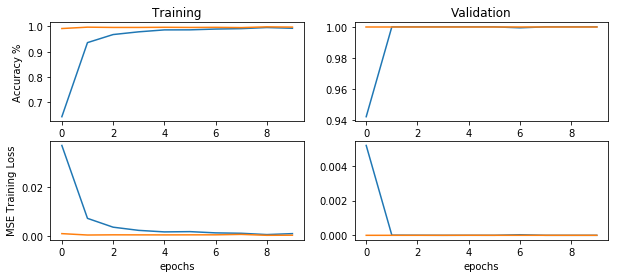

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
for i in range(len(history)):
    plt.plot(history[i].history['acc'])
    plt.ylabel('Accuracy %')
    plt.title('Training')

for i in range(len(history)):
    plt.subplot(2,2,2)
    plt.plot(history[i].history['val_acc'])
    plt.title('Validation')

for i in range(len(history)):
    plt.subplot(2,2,3)
    plt.plot(history[i].history['loss'])
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')

for i in range(len(history)):
    plt.subplot(2,2,4)
    plt.plot(history[i].history['val_loss'])
    plt.xlabel('epochs')

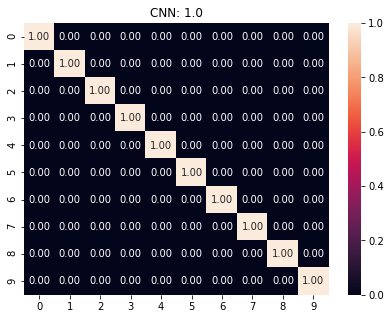

In [ ]:

compare_mlp_cnn(cnn3,x_test,y_test)

In our Alexnet result, our validation accuracy is basically 1. And the training loss decreas drastically. We think this increase in validation accuracy reasults from the data extention procedure. The network becomes more robust with augmented training data set while there is no data augmentation in validation.

## 3. Compare with MLP

### 3.1 MLP Data Preparation

In [ ]:
x_train_mlp = []
y_train_mlp = [] 
i = 0
for fruit in fruits:
    fruit_dir_path = "fruits-360/Training/" + fruit
    fruit_label = fruit_dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (32, 32))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image = image.reshape(1024)
        x_train_mlp.append(image)
        y_train_mlp.append(i)
    i = i + 1

x_train_mlp = np.array(x_train_mlp)
y_train_mlp = np.array(y_train_mlp)

x_test_mlp = []
y_test_mlp = [] 
i = 0
for fruit in fruits:
    fruit_dir_path = "fruits-360/Test/" + fruit
    fruit_label = fruit_dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (32, 32))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image = image.reshape(1024)
        x_test_mlp.append(image)
        y_test_mlp.append(i)
    i = i + 1
    
x_test_mlp = np.array(x_test_mlp)
y_test_mlp = np.array(y_test_mlp)

### 3.2 MLP Modeling

In [ ]:
y_train_mlp_ohe = keras.utils.to_categorical(y_train_mlp, NUM_CLASSES)
y_test_mlp_ohe = keras.utils.to_categorical(y_test_mlp, NUM_CLASSES)

# make a keras MLP
mlp = Sequential()
mlp.add( Dense(input_dim=1024, units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add(BatchNormalization())
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(mlp.summary())

mlp.fit(x_train_mlp, y_train_mlp_ohe, 
        batch_size=32, epochs=15, 
        shuffle=True, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 100)               102500    
_________________________________________________________________
dense_24 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_25 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_26 (Dense)             (None, 14)                714       
_________________________________________________________________
batch_normalization_4 (Batch (None, 14)                56        
_________________________________________________________________
activation_246 (Activation)  (None, 14)                0         
Total params: 110,870
Trainable params: 110,842
Non-trainable params: 28
_________________________________________________________________
Non

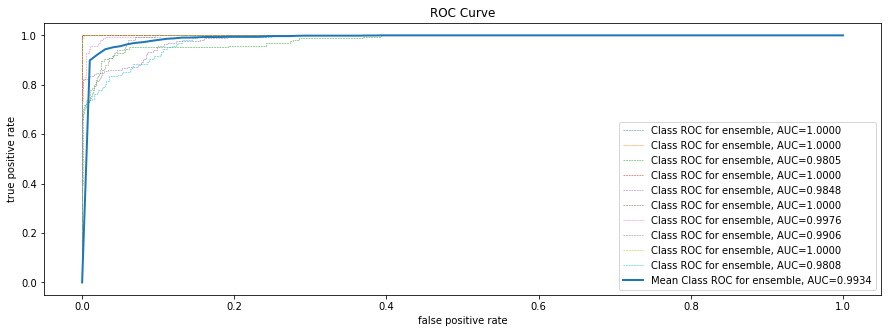

In [ ]:
probas = mlp.predict_proba(x_test_mlp)
plot_roc(probas, y_test_mlp)

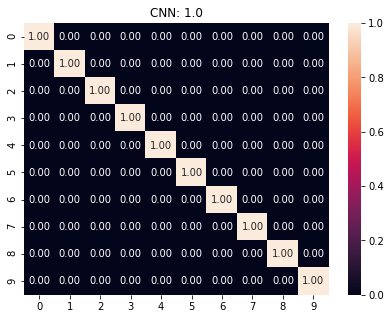

In [ ]:
compare_mlp_cnn(cnn3,x_test,y_test)

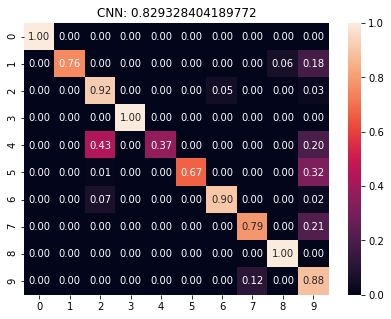

In [ ]:
compare_mlp_cnn(mlp,x_test_mlp,y_test_mlp)

CNN has cleary better accuarcy score than MLP and also better training rate as expected.

## 3. Exceptioal Work

In general, transfer learning uses existing knowledge to learn new knowledge. The core is to find the similarity between existing knowledge and new knowledge. Since the cost of learning directly from the beginning of the target domain is too high, we turn to the use of relevant knowledge to assist in learning new knowledge as quickly as possible. For example, if you have already played Chinese chess, you can learn chess in analogy. If you have written a Java program, you can learn C# analogously. If you have learned English, you can learn French in analogy. Everything in the world has commonalities. How to reasonably find similarities between them and use this bridge to help learn new knowledge is the core issue of transfer learning.


In [ ]:
from keras import applications
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model

In [ ]:

model = applications.VGG19(weights = "imagenet")

# a new layer 
x = model.output

# fully-connected layer

x = Dense(1024, activation='relu',kernel_initializer='he_uniform')(x)

predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=model.input, outputs=predictions)

for layer in model.layers:
    layer.trainable = False
    
#default size is (224 224 3)
x_train_up = [imresize(x,size=(224,224,3), interp='nearest') for x in x_train]
x_train_up = np.stack(x_train_up,axis=0)
print(x_train_up.shape)

x_test_up = [imresize(x,size=(224,224,3), interp='nearest') for x in x_test]
x_test_up = np.stack(x_test_up,axis=0)
print(x_test_up.shape)

C:\Users\zhang\Anaconda\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(4834, 224, 224, 3)


C:\Users\zhang\Anaconda\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(1623, 224, 224, 3)


In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
%%time 
model.fit(x_train_up,y_train_ohot,epochs=1,batch_size=16,verbose=1)

Epoch 1/1
4834/4834 [==============================] - 1124s 232ms/step - loss: 2.6456 - acc: 0.0683
Wall time: 18min 43s


In [ ]:
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))

In [ ]:
summarize_net(model, x_test_up, y_test, title_text='Transfer Learning MODEL VGG19')

There are five pre-trained models
Xception VGG16 VGG19 ResNet50 Inceptionv3
And we usde VGG19 to provides our pre-trained weights.
The processing time for each epoch may take more than 20 minutes in my pc, and the accuracy is 0.068 only for the first epoch. Which is better than our simple CNN but worse than the network with Batch Normalization.
We prefer our models with Batch Normalization in this situation that the pictures are smaller and the dataset is not large enough.

## 4.Reference

[1] https://www.kaggle.com/moltean/fruits